# Single city evaluation

In [11]:
fig, ax = plt.subplots(figsize=(12,9))

import h3.api.numpy_int as h3
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import numpy as np
import pandas as pd

plt.hexbin(distances['x'], distances['y'], C=distances['diff'], cmap='inferno',gridsize=100) #YlOrRd
plt.clim(vmin = 0, vmax = 20)
cb = plt.colorbar(shrink=0.75)

plt.scatter(origin['x'], origin['y'], c='b',marker="*", s=100)
plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
plt.xlim(12.35,12.70)
plt.ylim(55.55,55.79)

cx.add_basemap(ax=ax,
               crs="EPSG:4326",
               source=cx.providers.CartoDB.Positron
              )
plt.savefig('figures/bike_benefit.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
ds.keys()

In [ ]:
def routing(category_set, origins, destinations, num_origins, graph):
    mins = {}
    category_travel_time_means = {}
    for c in category_set:
        cat_destinations = list(destinations[destinations["category"] == c]["h3_index"])
        ds = graph.matrix_distance(
            origins=origins,
            destinations=cat_destinations,
            dynamic_infinity=True,
            hour_of_week=None,
        )

        # they might be different lengths, so we can't use a df
        mins[c] = {
            k: np.nanmin(np.array(v, dtype=np.float64)) for k, v in ds.items() if v
        }
        category_travel_time_means[c] = np.nanmean(list(mins[c].values()))

    return category_travel_time_means, mins

## Parameters

Select city name, osm file, ghsl file and gtfs feed

In [ ]:
FRESH_RUN = False

In [ ]:
# # denver, cl
#osm_file = "../resources/denver/denver-processed.osm.pbf"
#gtfs_files = ["../resources/denver/denver_gtfs.zip"]
#ghsl_file = "../resources/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0_R5_C10.tif"

#city_names = ["Denver, Colorado"]

# copehagen, dk
# osm_file = "../resources/processed/København Kommune_processed.osm.pbf"
# gtfs_files = ["../resources/copenhagen/rejseplanen.zip"]
# ghsl_file = "../resources/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0_R3_C19_Denmark.tif"

# city_names = ["København Kommune", "Frederiksberg Kommune"]

# city_names = ["Dragør Kommune"]
# osm_file = "../resources/processed/Dragør Kommune_processed.osm.pbf"
# gtfs_files = ["../resources/copenhagen/rejseplanen.zip"]
# ghsl_file = "../resources/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0_R3_C19_Denmark.tif"

# # Los Angeles
# osm_file = "../resources/la/la-processed.osm.pbf"
# gtfs_files = ["../resources/la/gtfs_bus.zip", "../resources/la/gtfs_rail.zip"]
# ghsl_file = "../resources/la/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0_R5_C8_SoCal.tif"

# city_names = ["Los Angeles"]

# Inputs
city_name = "København Kommune"
osm_file = '../resources/osm/København Kommune_processed.osm.pbf'
# public transport
gtfs_paths = ["../resources/rejseplanen_GTFS.zip"]
# ghsl data for building types
#tif_paths = ['../resources/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0_R3_C19_Denmark.tif', '../resources/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0_R3_C19_Denmark.tif']
tif_paths = ['../resources/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0_R3_C19_Denmark.tif']

In [ ]:
# Parameters

# 12 is around 10 meter resolution
H3_RES = 12

# how many origins to sample
num_origins = 10000

# essential filter will be the least restrictive
essential_filter = {
    "amenity": ["pharmacy", "dentist", "clinic", "doctors", "school", "library"],
    "shop": ["supermarket", "greengrocer", "medical_supply", "grocery", "wholesale"],
    "healthcare": ["clinic", "doctor", "pharmacy", "dentist"],
    "leisure": ["park", "fitness_centre", "fitness_station"],
    "sport": [
        "tennis",
        "soccer",
        "swimming_pool",
        "sports_centre",
        "pitch",
        "track",
        "golf_course",
        "gymnastics",
        "gym",
        "fitness_centre",
        "fitness_station",
    ],
}

# categories considered for the n-minute calculation
category_set = ["pharmacy", "park", "supermarket", "sport", "school", "library"]

# how to map osm tags to categories
osm_tag_mapping = {
    "medical_supply": "pharmacy",
    "greengrocer": "supermarket",
    "wholesale": "supermarket",
    "grocery": "supermarket",
    "clinic": "doctor",
    "doctors": "doctor",
    "pitch": "sport",
    "track": "sport",
    "sports_centre": "sport",
    "fitness_centre": "sport",
    "fitness_station": "sport",
}

## Run simulation

In [ ]:
if FRESH_RUN:
        results = {}

        city_bounds_h3, bbox, bbox_pois = city_boundaries_to_h3(city_names)

        origins = get_origins(H3_RES, city_names, bbox, ghsl_file, city_bounds_h3)
        print("origins", len(origins))

        origins_sample = list(origins[origins['residential_bool']==1].sample(num_origins, replace=True)['h3_index'])

        destinations = get_pois_h3(osm_file, essential_filter, H3_RES, category_set, osm_tag_mapping, city_names)

        # for g_type in ['all', 'walk', 'walk+bike', 'walk+transit']:
        for g_type in ['all']:
                print(g_type)
                # build the graph
                graph = PyH3Graph(weight_options={}, k_ring=2, layers=g_type)
                graph.create(osm_path=osm_file,gtfs_paths=gtfs_files)
                # do routing
                category_means, route_mins = routing(category_set, origins_sample, destinations, num_origins, graph)
                # save results as dictionary
                results.update({g_type:{'category_means':category_means, 'route_mins':route_mins}})

        result_data = []
        for g_type, result in results.items():
                route_mins = result['route_mins']
                for category, values in route_mins.items():
                        for h3_index, value in values.items():
                                lat, lon = h3.h3_to_geo(h3_index)
                                result_data.append([g_type, category, h3_index, lat, lon, value])

        result_df = pl.DataFrame(result_data, columns=['graph_type', 'category', 'h3', 'lat', 'lon', 'travel_time'])

        result_df.write_ipc(f'results_{city_names[0]}.feather')
else:
        result_df = pl.read_ipc(f'results_{city_names[0]}.feather')

In [ ]:
plot_df = result_df.filter((pl.col("travel_time").is_not_nan()))

In [ ]:
ggplot(plot_df.sample(1000)) + \
    geom_livemap(tiles=tilesets.CARTO_POSITRON_NO_LABELS) + \
    geom_point(aes(x='lon', y='lat'), size=1.5, alpha=0.7) + \
    ggtitle(f"Origins in Copenhagen") + \
    ggsize(1000, 800)

In [ ]:
# ggplot(plot_df.filter(pl.col('travel_time') < 60)) + \
#     geom_point(aes(x='lon', y='lat', color='travel_time'), alpha=0.5) + \
#     scale_color_gradient(low='#f2f0f7', high='#54278f') + \
#     facet_wrap(["graph_type", "category"], ncol=6) + \
#     coord_fixed() + \
#     ggtitle(f"Minimum travel times to essential services in [{city_names[0]}]") + \
#     ggsize(1000, 700)

## N-minute values by POI category
on the full network

In [ ]:
plot_df.filter(pl.col("graph_type") == "all").groupby("category").agg(
    pl.col("travel_time").mean().alias("mean_travel_time"),
    pl.col("travel_time").std().alias("std_travel_time"),
    pl.col("travel_time").median().alias("median_travel_time"),
    pl.col("travel_time").quantile(0.95).alias("95th_percentile_travel_time"),
)

## Dominant POI category distribution

In [ ]:
cat_df = (
    plot_df.filter((pl.col("graph_type") == "all") & (pl.col("category") != "library"))
    .groupby("h3")
    .agg(
        pl.col("travel_time").arg_max().alias("max_travel_time"),
        pl.col("category")
        .take(pl.col("travel_time").arg_max())
        .alias("max_travel_time_category"),
    )
    .groupby("max_travel_time_category")
    .agg(pl.col("h3").count().alias("num_origins"))
    .with_columns(pl.col("num_origins") / pl.col("num_origins").sum() * 100)
)

ggplot(cat_df) + geom_bar(
    aes(x="max_travel_time_category", y="num_origins"), stat="identity"
)

## Travel time benefits by network type

In [ ]:
(
    ggplot(plot_df)
    + geom_density(aes(x="travel_time", fill="category"), alpha=0.3)
    + xlim(0, 30)
    + facet_wrap(["graph_type"], ncol=5)
    + ggtitle(
        f"Minimum travel time to essential services in [{city_names[0]}], grouped by network type"
    )
)

In [ ]:
benefit_df = (
    plot_df.groupby(["h3", "category"])
    .agg(
        pl.col("travel_time"),
        pl.col("travel_time").len().alias("count"),
    )
    .filter(pl.col("count") == 4)
    .groupby(["h3", "category"])
    .agg(
        (
            pl.col("travel_time").flatten().take(1)
            - pl.col("travel_time").flatten().take(2)
        ).alias("bike_benefit"),
        (
            pl.col("travel_time").flatten().take(1)
            - pl.col("travel_time").flatten().take(3)
        ).alias("transit_benefit"),
        (
            pl.col("travel_time").flatten().take(1)
            - pl.col("travel_time").flatten().take(0)
        ).alias("multimodal_benefit"),
        (
            pl.col("travel_time").flatten().take(3)
            - pl.col("travel_time").flatten().take(2)
        ).alias("transit_bike_benefit"),
    )
    .sort("category")
)

In [ ]:
p = (
    ggplot(benefit_df)
    + geom_histogram(aes(x="multimodal_benefit", fill="category"), alpha=0.5, bins=30)
    + geom_vline(
        xintercept=benefit_df["multimodal_benefit"].quantile(0.5),
        linetype="dashed",
        color="black",
    )
    + geom_vline(
        xintercept=benefit_df["multimodal_benefit"].quantile(0.8),
        linetype="dashed",
        color="black",
    )
    + geom_vline(
        xintercept=benefit_df["multimodal_benefit"].quantile(0.9),
        linetype="dashed",
        color="black",
    )
    + xlim(0, 30)
    + xlab("benefit in minutes")
)

ggsave(p, f"multimodal_benefit_{city_names[0]}.png")

p.show()

In [ ]:
benefit_df.groupby("category").agg(
    pl.col("bike_benefit").mean().alias("bike_benefit"),
    pl.col("transit_benefit").mean().alias("transit_benefit"),
    pl.col("multimodal_benefit").mean().alias("multimodal_benefit"),
)

## N-minute values for each network type

In [ ]:
plot_df.filter(pl.col("category") != "library").groupby(["graph_type", "h3"]).agg(
    pl.col("travel_time").max().alias("max_travel_time"),
).groupby("graph_type").agg(
    pl.col("max_travel_time").median().alias("median_travel_time"),
    pl.col("max_travel_time").quantile(0.95).alias("95th_percentile_travel_time"),
)

In [ ]:
map_df = (
    plot_df.groupby(["graph_type", "h3"])
    .agg(
        pl.col("travel_time").max().alias("max_travel_time"),
        pl.col("lat").first().alias("lat"),
        pl.col("lon").first().alias("lon"),
    )
    .filter(pl.col("graph_type") == "all")
    .filter(
        (pl.col("max_travel_time") < pl.col("max_travel_time").quantile(0.95))
        & (pl.col("max_travel_time") > pl.col("max_travel_time").quantile(0.05))
    )
)

## Maps

In [ ]:
import geopandas as gpd

if "København Kommune" in city_names:
    # load data
    neis = gpd.read_file(
        "https://wfs-kbhkort.kk.dk/k101/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=k101:kvarter&outputFormat=json&SRSNAME=EPSG:4326"
    )[["kvarternavn", "geometry"]]

    frb = gpd.read_file(
        "https://admin.opendata.dk/dataset/f9cf5ee0-00bd-4ead-b5e8-4b3296b13e88/resource/5139ce4d-a08d-4f18-9fe0-6630661eb856/download/skoledistrikter.geojson"
    )
    frb = frb.to_crs(neis.crs).rename(columns={"navn": "kvarternavn"})[
        ["kvarternavn", "geometry"]
    ]

    neis = neis.append(frb)

    crs = neis.crs
    index = "kvarternavn"

    

elif "Denver, Colorado" in city_names:
    print("loading Denver data")
    neis = gpd.read_file("https://raw.githubusercontent.com/sclement07/datasets/main/neighbourhoods_denver.geojson")[["neighbourhood", "geometry"]]

    crs = neis.crs
    index = "neighbourhood"


data = gpd.GeoDataFrame(
    map_df.to_pandas(),
    geometry=gpd.points_from_xy(map_df["lon"], map_df["lat"]),
    crs=crs,
)

nei_data = (
        data.sjoin(neis, how="inner", op="intersects")
        .groupby(index)
        .median("max_travel_time")
        .reset_index()
    )

data_gdf = gpd.GeoDataFrame(
    nei_data.set_index(index)
    .join(neis.set_index(index), lsuffix="l", rsuffix="r")
    .reset_index()[[index, "max_travel_time", "geometry"]],
    crs=neis.crs,
)

p = (
    ggplot()
    + geom_livemap(tiles=tilesets.CARTO_POSITRON_NO_LABELS, zoom=11)
    + geom_polygon(
        aes(fill="n-minutes"),
        data=data_gdf.rename(columns={"max_travel_time": "n-minutes"}),
        alpha=0.8,
    )
    + scale_fill_continuous(low="#0000d9", high="#00d962", limits=[5, 17])
    + theme(legend_text=element_text(size=20), legend_title=element_text(size=20))
    + ggsize(1000, 800)
)

p.show()

In [ ]:
gpd.read_file("https://raw.githubusercontent.com/sclement07/datasets/main/neighbourhoods_denver.geojson")


In [ ]:
import plotly.figure_factory as ff
import plotly.express as px
import numpy as np

fig = ff.create_hexbin_mapbox(
    data_frame=map_df.filter(pl.col("graph_type") == "all").to_pandas(),
    lat="lat",
    lon="lon",
    nx_hexagon=60,
    opacity=0.7,
    labels={"color": "n"},
    template=None,
    color="max_travel_time",
    agg_func=np.mean,
    color_continuous_scale="thermal",
    range_color=[0, 30],
)
fig.update_layout(mapbox_style="carto-positron", width=1000, height=1000)
fig.update_traces(marker=dict(line=dict(width=0)))
fig.show()

### Single origin routing

In [7]:
# From 1 point to all others

# copehnagen hovedbanegard
hbg = {'x': 55.674599, 'y': 12.564449}
norreport = {'x': 55.683588, 'y': 12.571663}
origin = hbg
#convert point to h3
origin_h3 = [h3.geo_to_h3(origin['x'], origin['y'], H3_RES)]

results = {}

city_bounds_h3, bbox, bbox_pois = city_boundaries_to_h3([city_name])
origins_sample = origin_h3
destinations = get_pois_h3(osm_file, essential_filter, H3_RES, category_set, osm_tag_mapping, [city_name])
destinations = destinations['h3_index'].values

file already exists for København Kommune


In [14]:
weight_options = {'bike_penalty': 1.0,
                            'wait_time_multiplier': 1,
                            'walk_speed': 1.4,
                            'bike_speed': 4.5}


# build the graph
graph = PyH3Graph(weight_options=weight_options, k_ring=5, layers='all')
graph.create(osm_path=osm_file,gtfs_paths=gtfs_paths)
# do routing
ds_all = graph.matrix_distance(origins=destinations, destinations=origins_sample, dynamic_infinity=False)

graph = PyH3Graph(weight_options=weight_options, k_ring=5, layers='walk+transit')
graph.create(osm_path=osm_file,gtfs_paths=gtfs_paths)
# do routing
ds_wt = graph.matrix_distance(origins=destinations, destinations=origins_sample, dynamic_infinity=False)

processing osm pbf file: ../resources/osm/København Kommune_processed.osm.pbf
converted OSM file into 382287 edges
osm graph created with 326898 nodes in 24.910095 s
getting GTFS feed from ../resources/rejseplanen_GTFS.zip
routes: 1690
gtfs graph created with 104882 nodes in 46.629055 s
merged gtfs graph into osm graph, now has 430010 nodes, took 329 ms
hash: 11316098140308586906
processing osm pbf file: ../resources/osm/København Kommune_processed.osm.pbf
converted OSM file into 328446 edges
osm graph created with 274679 nodes in 7.708068 s
getting GTFS feed from ../resources/rejseplanen_GTFS.zip
routes: 1690
gtfs graph created with 104882 nodes in 34.901814 s
merged gtfs graph into osm graph, now has 377791 nodes, took 259 ms
hash: 11956091092678676292


In [15]:
distances_all = pd.DataFrame(ds_all).T
distances_wt = pd.DataFrame(ds_wt).T
# merge
distances = distances_all.merge(distances_wt, left_index=True, right_index=True)
distances.reset_index(inplace=True)
distances.columns = ['h3_index', 'all', 'walk+transit']
#get difference
distances['diff'] = distances['walk+transit'] - distances['all']
distances[['y','x']] = list(distances['h3_index'].apply(h3.h3_to_geo))

In [22]:
# remove nans from all and walk+transit
distances = distances[~distances['all'].isna()]
distances = distances[~distances['walk+transit'].isna()]

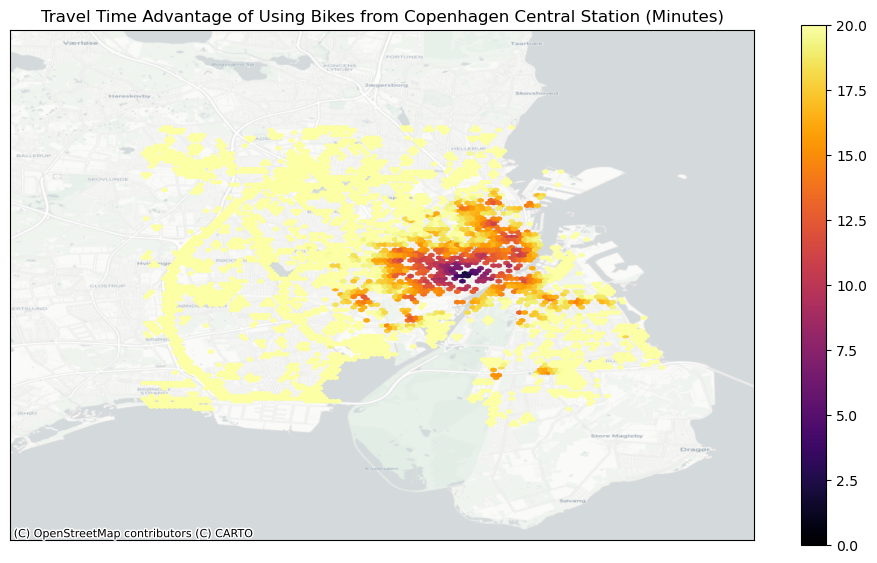

In [23]:
fig, ax = plt.subplots(figsize=(12,9))

plt.title('Travel Time Advantage of Using Bikes from Copenhagen Central Station (Minutes)')

plt.hexbin(distances['x'], distances['y'], C=distances['all'], cmap='inferno',gridsize=100) #YlOrRd
plt.clim(vmin = 0, vmax = 20)
cb = plt.colorbar(shrink=0.75)

plt.scatter(origin['x'], origin['y'], c='b',marker="*", s=100)
plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
plt.xlim(12.35,12.70)
plt.ylim(55.55,55.79)

cx.add_basemap(ax=ax,
               crs="EPSG:4326",
               source=cx.providers.CartoDB.Positron
              )
plt.savefig('figures/bike_benefit.png', dpi=300, bbox_inches='tight')
plt.show()

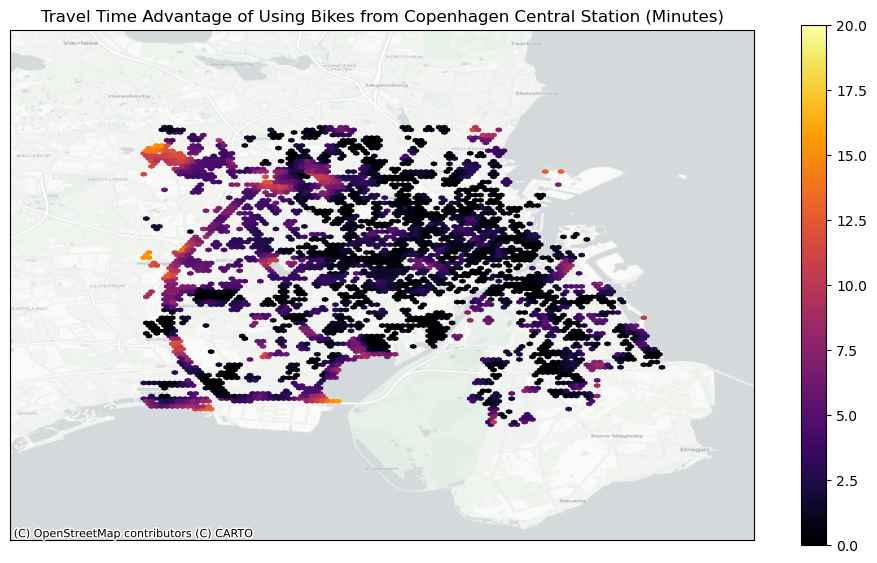

In [18]:
fig, ax = plt.subplots(figsize=(12,9))

plt.title('Travel Time Advantage of Using Bikes from Copenhagen Central Station (Minutes)')

plt.hexbin(distances['x'], distances['y'], C=distances['diff'], cmap='inferno',gridsize=100) #YlOrRd
plt.clim(vmin = 0, vmax = 20)
cb = plt.colorbar(shrink=0.75)

plt.scatter(origin['x'], origin['y'], c='b',marker="*", s=100)
plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
plt.xlim(12.35,12.70)
plt.ylim(55.55,55.79)

cx.add_basemap(ax=ax,
               crs="EPSG:4326",
               source=cx.providers.CartoDB.Positron
              )
plt.savefig('figures/bike_benefit.png', dpi=300, bbox_inches='tight')
plt.show()